## Neural Network model for skin cancer recognition

The following notebook contains different methods and takes for creating a model to use for the skin cancer detection app called Medical AI.

The Dataset used is a resized version of this dataset: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000. All the images have been resized to 256x256.

The goal is to train multiple models in order to see which one performs best for our application.


## 1. Importing libraries

Here we import the different libraries and initialize some default values

In [1]:
import numpy as np
import pandas as pd
import os

import cv2
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D

# For generating more images
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

# Configuration variables
BATCH_SIZE = 16
EPOCHS = 50
IMG_SIZE = (128,128)
TEST_RATIO = 0.20
NUM_CLASSES = 7

## 2. Reading and processing the dataset

Here we will read the CSV. We only care about the path and cell_type index, but maybe adding the age and other stuff will give better results.

In [2]:
# Directory and files variables
CSV_PATH = "../input/ham10000-resized/HAM10000.csv"
TRAIN_PATH = "../input/ham10000-resized/HAM10000"

In [3]:
df = pd.read_csv(CSV_PATH)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
# From the above, we drop the unnecessary rows
df.drop(['lesion_id', 'dx_type','age','sex','localization'], axis=1, inplace=True)
df.head()

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [5]:
# The 'dx' is the target that we want to predict. We can see below what are the unique values of the 'dx'
print("Unique dx:",df.dx.unique())

# We can define a dictionary with their full name, which could be useful in the future
dx_names = df.dx.unique()
full_name_dx = {'bkl':'Benign keratosis-like lesions',
               'nv':'Melanocytic nevi',
               'df':'Dermatofibroma',
               'mel':'Melanoma',
               'vasc':'Vascular lesions',
               'bcc':'Basal cell carcinoma',
               'akiec':'Actinic keratoses'}
classes = ['bkl','nv','df','mel','vasc','bcc','akiec']

Unique dx: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [6]:
# Encoding the targets in values from 0 to 7, and changing the name of the row from dx, to target

def encode_targets(x):
    # We hard code the function so that we are sure what the values are encoded
    if x == "bkl":
        return 0
    if x == "nv":
        return 1
    if x == "df":
        return 2
    if x == "mel":
        return 3
    if x == "vasc":
        return 4
    if x == "bcc":
        return 5
    if x == "akiec":
        return 6
    
df['target'] = df['dx'].apply(lambda x: encode_targets(x))
df['image_id'] = df['image_id'].apply(lambda x: str(x)+".jpg")
df.drop(['dx'], axis=1, inplace=True)
df.head()

,image_id,target
0,ISIC_0027419.jpg,0
1,ISIC_0025030.jpg,0
2,ISIC_0026769.jpg,0
3,ISIC_0025661.jpg,0
4,ISIC_0031633.jpg,0


## 3. Preparing the data for training

To prepare the data for training, we need to read the images and save them into arrays that we can feed to the models.


In [7]:
from tqdm import tqdm
X = []
y = []
# cv2.reize(cv2.imread(x),IMG_SIZE)
for i in tqdm(range(len(df))):
    img = cv2.resize(cv2.imread(os.path.join(TRAIN_PATH,df.iloc[i].image_id)),IMG_SIZE)
    X.append(img)
    y.append(df.iloc[i].target)
    
X = np.asarray(X)
y = np.asarray(y)

y = to_categorical(y, num_classes = NUM_CLASSES)

100%|██████████| 10015/10015 [01:02<00:00, 160.74it/s]


In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = TEST_RATIO, shuffle = True, random_state = 12345)
print("Number of training images: ",x_train.shape[0])
print("Number of testing images: ",x_test.shape[0])

Number of training images:  8012
Number of testing images:  2003


## 4. Creating the model and auxiliary functions

In [9]:
def create_model(X,y,X_tst,y_tst,model,epochs = 50,batch_size = 16):
    
    # Creating a generator for generating multiple images
    datagen = ImageDataGenerator(zca_whitening=False, # no zca whitening
                                 rotation_range=45,  # max 45 degrees rotations
                                 width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
                                 height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
                                 zoom_range = 0.1, # max 10% zoom on the image. Not bigger because it could take out a big part of the lesion
                                 horizontal_flip=True,  # random flip horizontal
                                 vertical_flip=True)  # random flip vertical    
    datagen.fit(X)
    
    
    x = model.output # Take the last layer of our model ...
    x = GlobalAveragePooling2D()(x) # ... then we append a GlobalAveragePooling2D layer to it.      
    x = Dense(1024, activation='relu')(x) # After we add a layer with 1024 dense nodes that have a relu activation
    x = Dropout(0.25)(x) # Add a dropout of 25% 
    
    x = Dense(NUM_CLASSES, activation='softmax')(x) # The final layer is the output which has 7 classes (NUM_CLASSES)
    
    model = Model(inputs=model.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        
    # Creating a callback for when we train, that reduces the learning rate
    # when we hit a plateau of 3 Epochs where we don't have an improvement
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.000005)
    
    # Start training the data
    history = model.fit_generator(datagen.flow(X,
                                               y, 
                                               batch_size=batch_size),                                  
                                  steps_per_epoch=X.shape[0] // batch_size,
                                  validation_steps=X_tst.shape[0] // batch_size,
                                  epochs=epochs,
                                  validation_data=(X_tst,y_tst), # We don't apply the ImageDataGenerator on the validation data
                                  callbacks=[learning_rate_reduction],
                                  verbose = 1)
    
    return model,history

In [10]:
!pip install -U git+https://github.com/qubvel/efficientnet
import efficientnet.keras as efn
weights_models = 'imagenet'

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-017ympmv
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-017ympmv
     |████████████████████████████████| 50 kB 245 kB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18433 sha256=42ad086d813043b1e69de11039cd06712f660d4b9260544aa46170f9cf78894e
  Stored in directory: /tmp/pip-ephem-wheel-cache-xx8ibtku/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [11]:
def train_and_test(x_train,y_train,x_test,y_test,mod,mod_name):
    # Get the model and the model history, to plot it later 
    model,model_history = create_model(x_train,y_train,x_test,y_test,mod)
    mod_name="TST"
    model.save(str(mod_name)+".h5")
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)

    print("Evaluation on test dataset: Accuracy: {:.4f} || Loss = {:.4f}".format(accuracy, loss))

    pred = model.predict(x_test)

    pred = np.argmax(pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Printing confusion matrix. The values after are the accuracies, in order")
    cfm = confusion_matrix(y_test,pred)
    print(cfm)
    print("Accuracies:")
    for i in range(len(cfm)):
        t = 0
        n = 0
        for j in range(len(cfm)):
            if j == i:
                t += cfm[i][j]
            else:
                n += cfm[i][j]

        print("{}: {:2f}".format(classes[i],t/(t+n)))


    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("\n~~ Calculating the F1-Weighted scode ~~\n")
    print("F1 Weighted:",f1_score(y_test, pred, average='weighted'))


    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


31940608/31936256 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
500/500 [==============================] - 80s 121ms/step - loss: 0.9970 - accuracy: 0.6681 - val_loss: 0.7818 - val_accuracy: 0.7524
Epoch 2/50
500/500 [==============================] - 54s 108ms/step - loss: 0.7269 - accuracy: 0.7465
Epoch 3/50
500/500 [==============================] - 58s 116ms/step - loss: 0.6464 - accuracy: 0.7665
Epoch 4/50
500/500 [==============================] - 57s 113ms/step - loss: 0.6301 - accuracy: 0.7749
Epoch 5/50
500/500 [==============================] - 57s 114ms/step - loss: 0.5863 - accuracy: 0.7871
Epoch 6/50
500/500 [==============================] - 56s 112ms/step - loss: 0.5649 - accuracy: 0.8036
Epoch 7/50
500/500 [==============================] - 57s 113ms/step - loss: 0.5860 - accuracy: 0.7855
Epoch 8/50
500/500 [==============================] - 58s 116ms/step - loss: 0.5187 - accuracy: 0.8108
Epoch 9/50
500/500 [==============================] - 59s 118ms/step - loss: 0.5207 - accuracy: 0.8145
Epoch 10/50
500/500 [==========

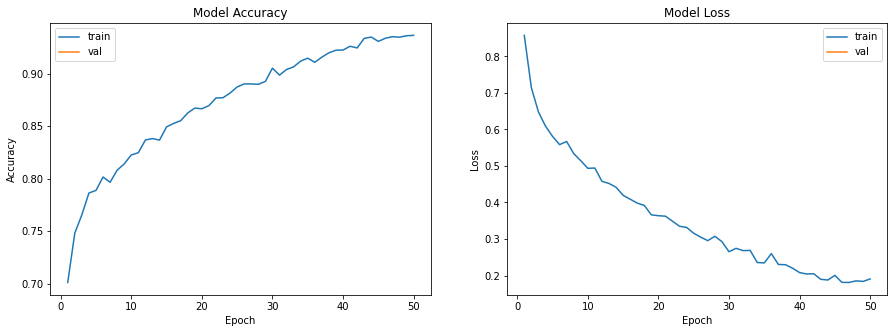

In [12]:
from keras.applications import ResNet50V2

mod = efn.EfficientNetB2(input_shape = (128,128,3), 
                                            weights=weights_models,
                                            include_top=False)

train_and_test(x_train,y_train,x_test,y_test,mod,"EfficientNetB2")